In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

## choose file either with the run number (first cell) or widget (second cell)

In [2]:
pgroup='p20537'
runnumber = 175
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
jsonfile

run: 0175


'/sf/alvra/data/p20537/raw/run0175-FePhen_timescan_7119p5eV_010/meta/scan.json'

In [2]:
fc = FileChooser('/sf/alvra/data/p20537/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p20537/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [ ]:
jsonfile = copy.copy(fc.selected)
jsonfile

In [5]:
quantile_corr = 0.5

Timezero_mm = 199.38 ## this in mm from the timescans 5.12 - 06:50 night

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
flag = False

try:
    flag = True
    Timezero_mm = get_timezero_NBS(jsonfile)
except:
    Timezero_mm = Timezero_mm
        
(DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
 Izero_pump_scan, Izero_unpump_scan, correlation, Delay_mm, Delay_fs, goodshots) = \
XAS_delayscan_noTT(scan, detector_XAS, detector_Izero, quantile_corr)

if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)

Processing: run0175-FePhen_timescan_7119p5eV_010
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY  998 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 998 / 1001 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 497 pump and 497 unpump shots
(145,) shots out of (497,) survived
Step 56 of 56: Processed acq0056
correlation Diode (all shots) = 0.992964026221076
Timezero found in file = 199.379920000045 mm


Position t0 = 408.5525 from 199.3799 mm
Width = 158.8996 fs


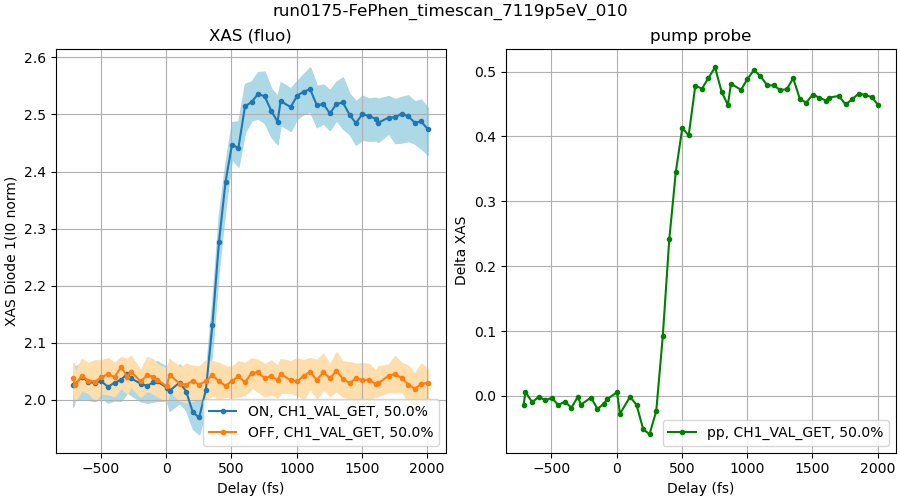

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3], fontsize = 12)

XAS_pump = DataDiode_pump[:,0]
err_low_pump = DataDiode_pump[:,1]
err_high_pump = DataDiode_pump[:,2]
XAS_unpump = DataDiode_unpump[:,0]
err_low_unpump = DataDiode_unpump[:,1]
err_high_unpump = DataDiode_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode[:,0]
err_low_pump_probe = Pump_probe_Diode[:,1]
err_high_pump_probe = Pump_probe_Diode[:,2]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS_pump_probe)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
fit.fit(Delay_fs,XAS_pump_probe)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting
t0_mm = fit.popt[0]
width_fs = fit.popt[2]

print("Position t0 = {:.4f} from {:.4f} mm".format(t0_mm, Timezero_mm))
print("Width = {:.4f} fs".format(width_fs))

ax1.plot(Delay_fs, XAS_pump, label='ON, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS_unpump, label='OFF, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS_pump_probe, label='pp, {}, {}%'.format(detector_XAS.split(':')[-1], quantile_corr*100),marker='.', color = 'g')
#ax2.plot(Delay_fs, pp_fit)
#ax2.fill_between(Delay_fs, err_low_pump_probe, err_high_pump_probe, color='lightgreen')

ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()

## Check correlation for a certain delay point

In [11]:
chosen_delay_fs = 250

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

(182,) shots out of (495,) survived
Delay = 252.84 fs


In [12]:
from scipy import stats
#m,b = np.polyfit(Izero_pump,Fluo_pump, 1)
#m_filter,b_filter = np.polyfit(Izero_pump_filter,Fluo_pump_filter, 1)
m_median = np.median(Fluo_pump/Izero_pump)
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)
print ("Median (all) = {}, Median (filtered) = {}".format(m_median, m_median_filter))

MAD = stats.median_absolute_deviation(Fluo_pump/Izero_pump)
MAD_filter = stats.median_absolute_deviation(Fluo_pump_filter/Izero_pump_filter)

print ("MAD (all) = {}, MAD(filtered) = {}".format(MAD, MAD_filter))

print ("MAD/median (all) = {}%, MAD/median (filtered) = {}%".format(MAD/m_median*100, MAD_filter/m_median_filter*100))

Median (all) = 1.9690541247633333, Median (filtered) = 1.967633067649395
MAD (all) = 0.09959005206160838, MAD(filtered) = 0.050575777349410087
MAD/median (all) = 5.057761023891531%, MAD/median (filtered) = 2.570386632596581%


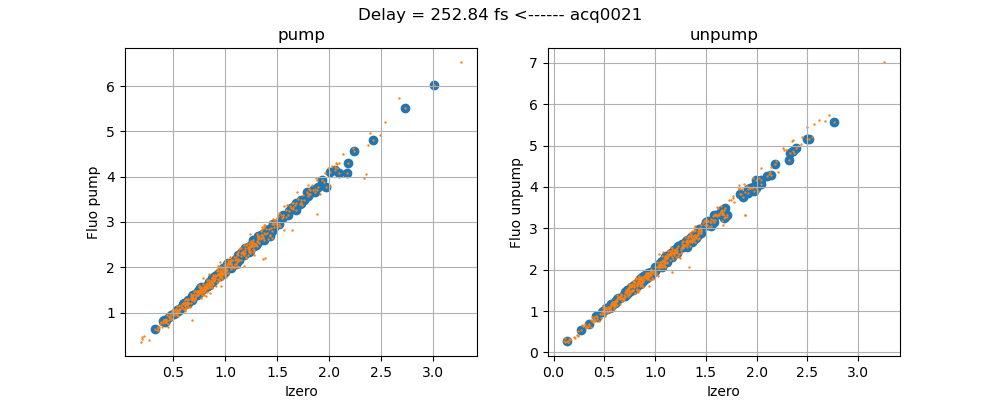

In [13]:
plt.figure(figsize=(10,4))
plt.suptitle('Delay = {:.2f} fs <------ {}'.format(Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump_filter, Fluo_pump_filter)
plt.scatter(Izero_pump, Fluo_pump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter)
plt.scatter(Izero_unpump, Fluo_unpump, s = 0.5)
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

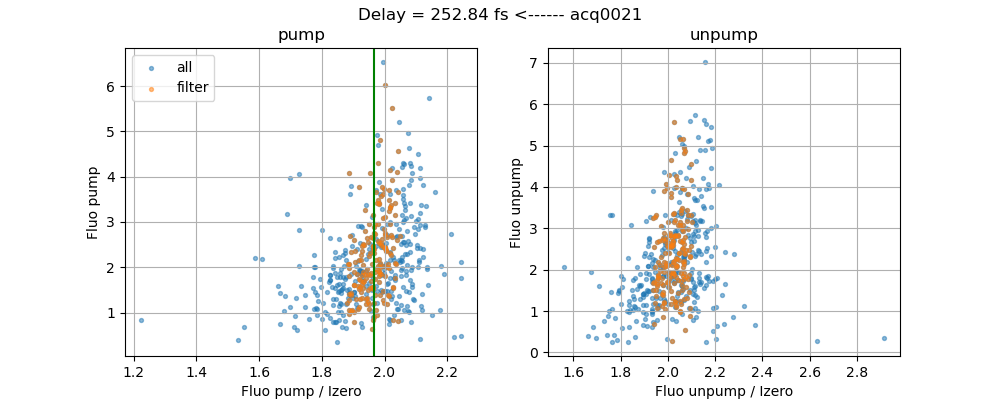

In [14]:
plt.figure(figsize=(10,4))
plt.suptitle('Delay = {:.2f} fs <------ {}'.format(Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Fluo_pump/Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_pump_filter/Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.legend(loc='best')
plt.xlabel('Fluo pump / Izero')
plt.ylabel('Fluo pump')
plt.grid()


plt.subplot(122)
plt.title('unpump')
plt.scatter(Fluo_unpump/Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_unpump_filter/Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
plt.xlabel('Fluo unpump / Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

# Loop of scans, WITHOUT TT correction

In [16]:
pgroup='p20537'
#runlist = [790]
runlist = np.arange(166, 176, 1)

print ('{} runs: {}'.format(len(runlist),runlist))

#############################################################
from itertools import chain
jsonlist = []
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    jsonlist.append(file)
jsonlist = itertools.chain.from_iterable(jsonlist)
jsonlist = sorted(jsonlist, key = os.path.getmtime)
jsonlist

10 runs: [166 167 168 169 170 171 172 173 174 175]


['/sf/alvra/data/p20537/raw/run0166-FePhen_timescan_7119p5eV_001/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0167-FePhen_timescan_7119p5eV_002/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0168-FePhen_timescan_7119p5eV_003/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0169-FePhen_timescan_7119p5eV_004/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0170-FePhen_timescan_7119p5eV_005/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0171-FePhen_timescan_7119p5eV_006/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0172-FePhen_timescan_7119p5eV_007/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0173-FePhen_timescan_7119p5eV_008/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0174-FePhen_timescan_7119p5eV_009/meta/scan.json',
 '/sf/alvra/data/p20537/raw/run0175-FePhen_timescan_7119p5eV_010/meta/scan.json']

In [36]:
quantile_corr = 0.6
Timezero_mm = 86.61422    ## this in mm from the YAG scans

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans/'

#######################################################################################################33
from sfdata import SFScanInfo

DataDiode_pump_all = []
DataDiode_unpump_all = []
Pump_probe_all = []
Delay_fs_all = []

for json_file in jsonlist[:2]:
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    flag = False
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm
    
    DataDiode_pump = []
    DataDiode_unpump = []
    Pump_probe_Diode = []
    
    (DataDiode_pump, DataDiode_unpump, Pump_probe_Diode,
     Izero_pump_scan, Izero_unpump_scan, correlation, Delay_mm, Delay_fs, goodshots) = \
    XAS_delayscan_noTT(scan, detector_XAS, detector_Izero, quantile_corr)
    
    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))
        
    if scan.parameters['units'] == ['nS']:
        Delay_fs = - scan.values
    #    Delay_fs = Delay_fs - 0.17
    else:
        Delay_fs = scan.values
        Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
    
    run_name = json_file.split('/')[-3]
    os.makedirs(reducedir+run_name, exist_ok=True)
    
    np.save(reducedir+run_name+'/timescan_Delay_fs.npy', Delay_fs)
    np.save(reducedir+run_name+'/timescan_Delay_fm.npy', Delay_mm)
    
    np.save(reducedir+run_name+'/timescan_goodshots1.npy', goodshots)
    np.save(reducedir+run_name+'/timescan_DataDiode1_pump', DataDiode_pump)
    np.save(reducedir+run_name+'/timescan_DataDiode1_unpump', DataDiode_unpump)
    np.save(reducedir+run_name+'/timescan_Pump_probe_Diode1', Pump_probe_Diode)
    
    DataDiode_pump_all.append(DataDiode_pump)
    DataDiode_unpump_all.append(DataDiode_unpump)
    Pump_probe_all.append(Pump_probe_Diode)
    Delay_fs_all.append(Delay_fs)
    
    print ('Processed run {}'.format(json_file.split('/')[-3]))

DataDiode_pump_all = np.array(DataDiode_pump_all)
DataDiode_unpump_all = np.array(DataDiode_unpump_all)
Pump_probe_all = np.array(Pump_probe_all)
Delay_fs_all = np.array(Delay_fs_all)


Processing: run0167-FePhen_timescan_7119p5eV_002
Step 56 of 56: Processing acq0056

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY 1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1001 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 499 pump and 499 unpump shots
(185,) shots out of (499,) survived
Step 56 of 56: Processed acq0056
correlation Diode (all shots) = 0.9953918599532973
------------------------------
Timezero found in file = 199.379920000045 mm
Processed run run0167-FePhen_timescan_7119p5eV_002


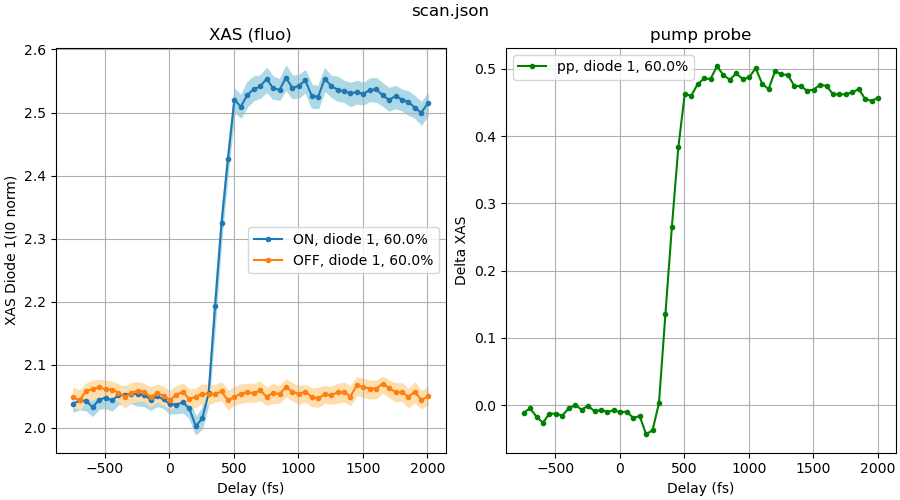

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-1], fontsize = 12)

XAS_pump = np.mean(DataDiode_pump_all, axis=0)[:,0]
err_low_pump = (XAS_pump - np.mean(DataDiode_pump_all, axis=0)[:,1])/np.sqrt(len(jsonlist))
err_high_pump = (np.mean(DataDiode_pump_all, axis=0)[:,2]-XAS_pump)/np.sqrt(len(jsonlist))
XAS_unpump = np.mean(DataDiode_unpump_all, axis=0)[:,0]
err_low_unpump = (XAS_unpump - np.mean(DataDiode_unpump_all, axis=0)[:,1])/np.sqrt(len(jsonlist))
err_high_unpump = (np.mean(DataDiode_unpump_all, axis =0)[:,2]-XAS_unpump)/np.sqrt(len(jsonlist))
XAS_pump_probe = np.mean(Pump_probe_all, axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all, axis=0)[:,1]/np.sqrt(len(jsonlist))
err_high_pump_probe = np.mean(Pump_probe_all, axis=0)[:,2]/np.sqrt(len(jsonlist))

Delay_fs_mean = np.mean(Delay_fs_all, axis=0)[:]

ax1.plot(Delay_fs_mean, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_pump - err_low_pump, XAS_pump + err_high_pump, color='lightblue')

ax1.plot(Delay_fs_mean, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs_mean, XAS_unpump - err_low_unpump, XAS_unpump + err_high_unpump, color='navajowhite')

ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs_mean, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
#ax2.fill_between(Delay_fs_mean, XAS_pump_probe - err_low_pump_probe, XAS_pump_probe + err_high_pump_probe, color='lightgreen')


ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.show()